# <font color='red'> 불량식품 신고민원 이상징후 사전감지 

In [3]:
name = ['a', 'b'] 
value = [1, 2] 
for n, v in zip(name, value): 
    print(n, v)

a b
1 2


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
#Configure Defaults
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family']='Malgun Gothic'
from IPython.display import Image
width = 800; height = 100
import missingno as msno
from tqdm import tqdm_notebook
# probability
from scipy.stats import poisson
from scipy.stats import chisquare
import math

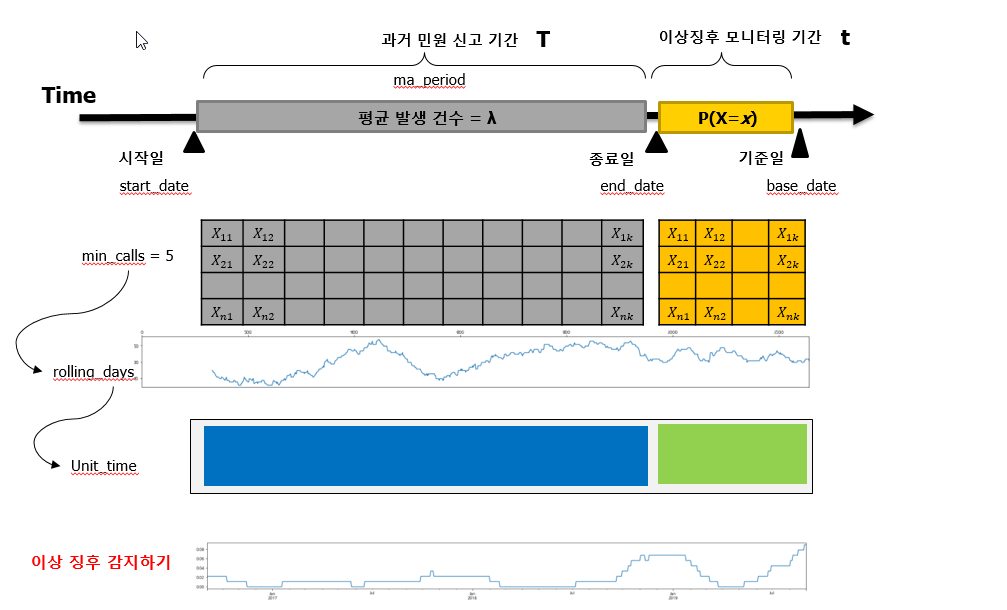

In [83]:
Image(filename='../images/graph1.png', width=800, height=300)

In [84]:
def summary(df) :
    pd.set_option('display.max_rows', 500)
    tf = pd.DataFrame({'데이터형태(dtypes)' : df.dtypes, 
                        '비 결측치 수(notnull' : df.notnull().sum(),
                        '결측치 수(null)' : df.isnull().sum(), 
                        '고유값 수(nunique)' : df.nunique()})
    return tf

def display_company(threshhold_inbound_calls, df) : 
    
    sf = (df.groupby('제조원')['신고건수'].sum() >= threshhold_inbound_calls).reset_index() # 제조원별 신고건수 Boolean
    sf['신고건수'] = sf['신고건수']*1 # 제조원별 신고건수
    target_co = sf[sf['신고건수'] == 1]['제조원'].to_list()
    print('대상업체 수', len(target_co))
    df.loc[df['제조원'].isin(target_co)].제조원.value_counts(normalize=True).plot(rot='30', figsize=(25,3)); plt.show()
    df.loc[df['제조원'].isin(target_co)].제조원.value_counts(normalize=True).plot.pie(autopct='%.2f', fontsize=12, figsize=(10,10)) ; plt.show()
    
    return 

def extract_company(threshhold_inbound_calls, df) : 
    
    sf = (df.groupby('제조원')['신고건수'].sum() >= threshhold_inbound_calls).reset_index() # 제조원별 신고건수 Boolean
    sf['신고건수'] = sf['신고건수']*1 # 제조원별 신고건수
    target_co = sf[sf['신고건수'] == 1]['제조원'].to_list()
    df['target'] = df['제조원'].apply(lambda x: 1 if x in target_co else 0) # 대상업체는 1로 아니면 0으로 기록
    tf = df[df['target'] == 1] # 대상업체인 데이터만 추출
    tf.drop(columns=['target'], inplace=True)
    print('대상업체 수', tf['제조원'].nunique())
    
    return tf

# 1. 데이터 전처리

In [85]:
df = pd.read_pickle('../1399_data/1399_dataset.pkl')
df = df[['신고일시', '제조원', '제품명']] # 필요컬럼만 추출

df['신고일시'] = df['신고일시'].dt.strftime('%Y-%m-%d') # 날짜를 datetype으로변환
df['신고일시'] = pd.to_datetime(df['신고일시'])
df['신고건수'] = 1

# 인텍스를 일련번호로 변환
df.index = np.arange(0, len(df))

# 신고일시의 결측치는 삭제, 제품명도 삭제 (제조원은 결측치가 19,281로 많아 대상에서 제외)
#df = df.dropna(subset=['제조원', '신고일시'])
df = df.dropna(subset=['제품명', '신고일시']) # 결측치 제거 (제조원, 신고일시의 결측치) 

In [86]:
summary(df) # 고유값의 수가 전체 신고민원대비 너무 많다. 

,데이터형태(dtypes),비 결측치 수(notnull,결측치 수(null),고유값 수(nunique)
신고일시,datetime64[ns],51290,0,1201
제조원,object,32540,18750,14872
제품명,object,51290,0,27673
신고건수,int64,51290,0,1


# 2. 데이터 현황분석
### 제조원/제품명과 신고건수

제조원 누적비율대비 누적 신고민원비율 (지니그래프) 

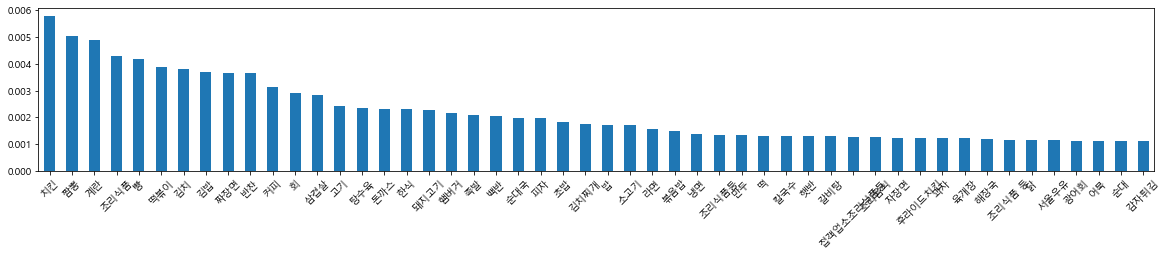

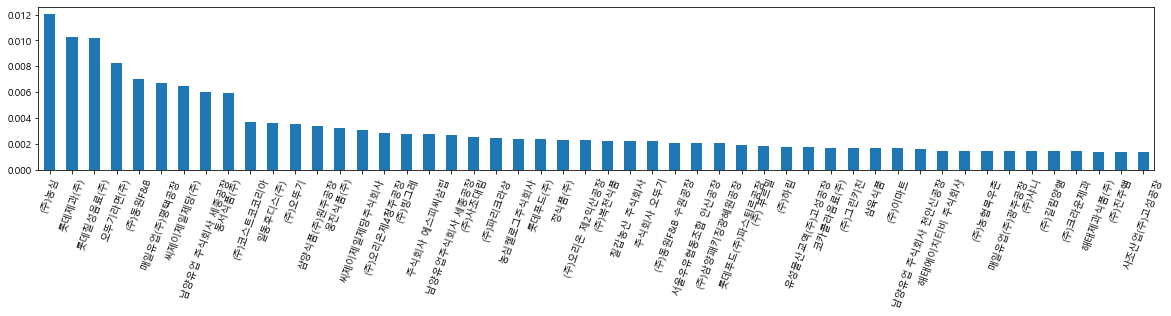

In [87]:
df.제품명.value_counts(normalize=True).nlargest(50).plot(kind='bar', rot= '45', figsize=(20,3)); plt.show()
df.제조원.value_counts(normalize=True).nlargest(50).plot(kind='bar', rot= '70', figsize=(20,3))

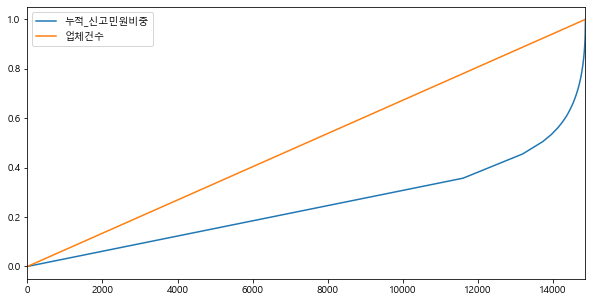

In [88]:
tf = df.제조원.value_counts(normalize=True).reset_index().sort_values(by='제조원', ascending=True)
tf.columns = ['제조원', '신고민원비중']; tf.index = np.arange(0, tf.shape[0])
tf['누적_신고민원비중'] = tf['신고민원비중'].cumsum()
tf['업체건수'] = 1/tf.shape[0]; tf['업체건수'] = tf['업체건수'].cumsum()
tf[['누적_신고민원비중', '업체건수']].plot(figsize=(10,5))

대상업체 수 40


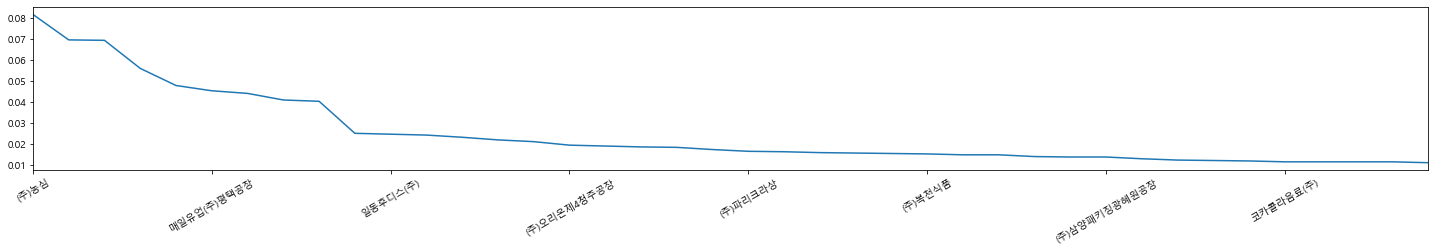

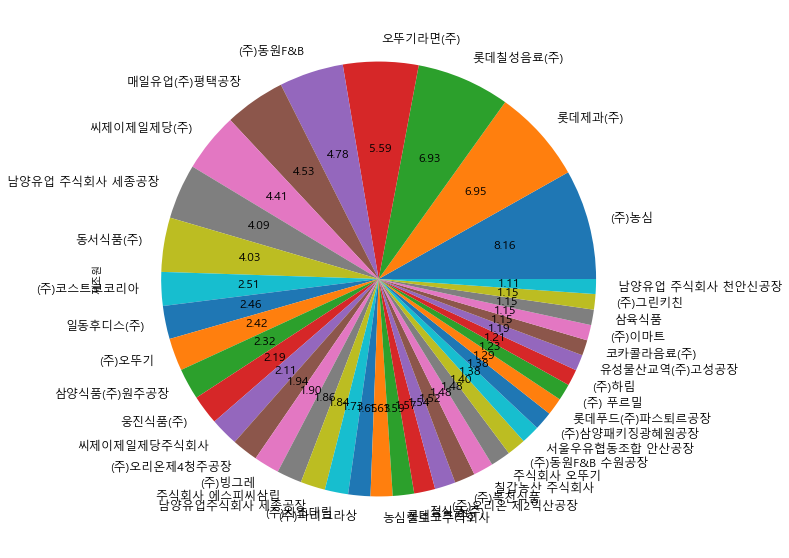

In [89]:
threshhold_inbound_calls = 50
display_company(threshhold_inbound_calls, df) # 최소 신고민원 건수(threshhold_inbound_calls)인 업체와 해당 데이터프레임

## 3.1 데이터추출을 위한 외부파라미터 설정

#### A. 시작일과 종료일, 기준일 설정

In [90]:
base_date = pd.to_datetime('2019-08-31') # 기준일
ma_period = 365*3 # 과거 민원신고기간(일수) days 혹은 이동평균산정 기간
alert_period = 30 # 이상징후 모니터링 기간(일수) days

#### B. 이동평균기간 설정

In [91]:
end_date = base_date - pd.Timedelta(str(alert_period) + ' days') # 종료일 자동 지정
start_date = end_date - pd.Timedelta(str(ma_period ) + ' days') # 시작일 자동지정

In [92]:
rolling_days = 90 # days
start_date - pd.Timedelta(str(rolling_days) + ' days')

Timestamp('2016-05-03 00:00:00')

#### C. 최소 신원민고건수 지정

In [93]:
min_calls = 5

#### D. 확인

In [94]:
print('모니터링 시작일은 {}이고, 종료일은 {}'.format(start_date, end_date))
print('모니터링 기간(일)은 {} 일'.format((end_date - start_date).days))

print('이상탐지 기간 시작일은 {}이고, 종료일은 {}'.format(end_date, base_date))
print('이상탐지 기간(일)은 {} 일'.format((pd.to_datetime(base_date)-end_date).days))

모니터링 시작일은 2016-08-01 00:00:00이고, 종료일은 2019-08-01 00:00:00
모니터링 기간(일)은 1095 일
이상탐지 기간 시작일은 2019-08-01 00:00:00이고, 종료일은 2019-08-31 00:00:00
이상탐지 기간(일)은 30 일


### 3.2 과거 민원기간동안만 데이터프레임으로 하고 최소 신고민원 이상인 업체를 대상으로 데이터 추출

In [95]:
df = extract_company(min_calls, df[(df['신고일시'] >= start_date - pd.Timedelta(str(rolling_days) + ' days')) &
                                   (df['신고일시'] <= base_date)]) # 적어도 과거에 5건의 민원신고 업체
summary(df)
df.head()

대상업체 수 722


,데이터형태(dtypes),비 결측치 수(notnull,결측치 수(null),고유값 수(nunique)
신고일시,datetime64[ns],10583,0,825
제조원,object,10583,0,722
제품명,object,10583,0,7165
신고건수,int64,10583,0,1


,신고일시,제조원,제품명,신고건수
12725,2016-05-03,주식회사 에스피씨삼립,주종발효단팥크림빵,1
12729,2016-05-03,하이트진로㈜ 청주공장,참이슬 fresh(참이슬후레쉬),1
12736,2016-05-03,(주)신영에이치에스,소스,1
12741,2016-05-03,주식회사 샬롬,서재걸의 리얼톡 해소과채,1
12743,2016-05-03,(주)사조오양금산공장,게맛살 한가족,1


#### <font color='blue'> validation with data

In [96]:
df[df['제조원'] == '(주)농심'].shape
df.head()
print('데이터에서 처음과 마지막 일자는 {}, {}'.format(df['신고일시'].min(), df['신고일시'].max()))

(277, 4)

,신고일시,제조원,제품명,신고건수
12725,2016-05-03,주식회사 에스피씨삼립,주종발효단팥크림빵,1
12729,2016-05-03,하이트진로㈜ 청주공장,참이슬 fresh(참이슬후레쉬),1
12736,2016-05-03,(주)신영에이치에스,소스,1
12741,2016-05-03,주식회사 샬롬,서재걸의 리얼톡 해소과채,1
12743,2016-05-03,(주)사조오양금산공장,게맛살 한가족,1


데이터에서 처음과 마지막 일자는 2016-05-03 00:00:00, 2019-08-30 00:00:00


## 3.3 시계열데이터 만들기 (업체별로 만들어 합치기)

#### <font color='blue'> validation with data

원본데이커의 크기 277와 시계열자료의 크기 277.0를 비교(크기는 신고민원건수)
****************************************************************************************************


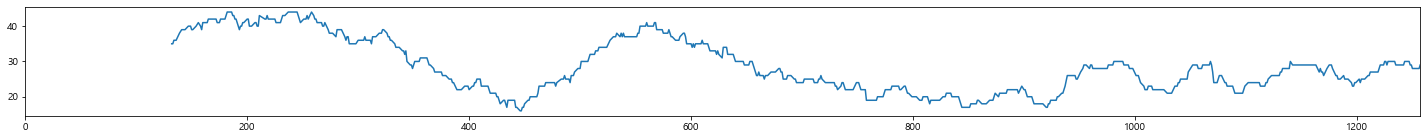

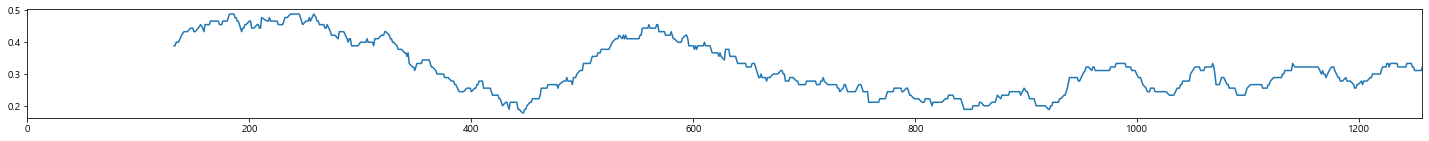

In [97]:
co_name = '(주)농심'

# 주중만 반영
tf = pd.DataFrame(pd.date_range('2016-05-03', '2019-08-30'))
tf.columns = ['date']
tf['day'] = tf['date'].apply(lambda x: x.weekday())

# 시계열 자료를 추축으로 merge
tf = pd.merge(tf, df[df['제조원'] == co_name], left_on='date', right_on='신고일시', how='left')
tf['신고건수'] = tf['신고건수'].fillna(0)
tf['제조원'] = tf['제조원'].fillna(co_name)
tf = tf[(tf['day'] != 5) & (tf['day'] != 6)] # 주중 데이터

# Conditional Replace Pandas with recording dupicated dates into my_dict
my_dict ={}
for i in tf[tf.duplicated(['date'])]['date'] :
    my_dict[i] = tf[tf['date'] == i]['신고건수'].sum()
    
for i, j in my_dict.items() :
    tf.loc[tf['date'] == i, '신고건수'] = j #tf['신고건수'] = tf['date'].apply(lambda x: int(j) if x == i else x)   
    
# 중복값 제거 (시계열 날자는 모두 살아있음)
tf = tf.drop_duplicates(['date'], keep='first')

# 확인
print('원본데이커의 크기 {}와 시계열자료의 크기 {}를 비교(크기는 신고민원건수)'.format(df[df['제조원'] == '(주)농심'].shape[0], tf['신고건수'].sum()))
print('*'*100)
# 이동평균값 구하기

rolling = tf['신고건수'].rolling(window = rolling_days) # 이동평균 기간(rolling_days)
rolling.sum().plot(figsize=(25,2)); plt.show()
rolling.mean().plot(figsize=(25,2))
tf['이동평균'] = rolling.mean()
tf['이동합계'] = rolling.sum()

tf = tf.set_index('date')

#### <font color='blue'> validation with data

In [98]:
tf = tf.dropna(subset=['이동평균']) # 이동평균이 없는 데이터의 행은 모두 삭제
summary(tf)
tf.head()

,데이터형태(dtypes),비 결측치 수(notnull,결측치 수(null),고유값 수(nunique)
day,int64,780,0,5
신고일시,datetime64[ns],206,574,206
제조원,object,780,0,1
제품명,object,206,574,106
신고건수,float64,780,0,4
이동평균,float64,780,0,29
이동합계,float64,780,0,29


,day,신고일시,제조원,제품명,신고건수,이동평균,이동합계
date,,,,,,,
2016-09-05,0,NaT,(주)농심,NaN,0.0,0.388889,35.0
2016-09-06,1,NaT,(주)농심,NaN,0.0,0.388889,35.0
2016-09-07,2,2016-09-07,(주)농심,신라면컵,1.0,0.400000,36.0
2016-09-08,3,NaT,(주)농심,NaN,0.0,0.400000,36.0
2016-09-09,4,NaT,(주)농심,NaN,0.0,0.400000,36.0


### A. 함수를 만들어업체별로 업체명과 이동평균값을 반환값으로 하는 시리즈를 쌓아 데이터프레임 만들기

In [99]:
def time_series_fbo(co_name, begin_date, end_date) : # 아래를 모두 선택하고 'tab'을 누르면 ident가 됨
    
    # 주중만 반영
    tf = pd.DataFrame(pd.date_range(begin_date, end_date))
    tf.columns = ['date']
    tf['day'] = tf['date'].apply(lambda x: x.weekday())

    # 시계열 자료를 추축으로 merge
    tf = pd.merge(tf, df[df['제조원'] == co_name], left_on='date', right_on='신고일시', how='left')
    tf['신고건수'] = tf['신고건수'].fillna(0)
    tf['제조원'] = tf['제조원'].fillna(co_name)
    tf = tf[(tf['day'] != 5) & (tf['day'] != 6)] # 주중 데이터

    # Conditional Replace Pandas with recording dupicated dates into my_dict
    my_dict ={}
    for i in tf[tf.duplicated(['date'])]['date'] :
        my_dict[i] = tf[tf['date'] == i]['신고건수'].sum()

    for i, j in my_dict.items() :
        tf.loc[tf['date'] == i, '신고건수'] = j #tf['신고건수'] = tf['date'].apply(lambda x: int(j) if x == i else x)   

    # 중복값 제거 (시계열 날자는 모두 살아있음)
    tf = tf.drop_duplicates(['date'], keep='first')

    # 이동평균값 구하기
    rolling = tf['신고건수'].rolling(window = rolling_days) # 이동평균 기간(rolling_days)
    tf['이동평균'] = rolling.mean()
    tf['이동합계'] = rolling.sum()
    
    tf = tf.set_index('date')
    
    return tf['이동평균']

In [100]:
my_dict = dict()
my_columns =[]

for co_name in df['제조원'].value_counts().reset_index()['index'].to_list() :
    tf = time_series_fbo(co_name, '2016-05-03', '2019-08-30')
    new_index = tf.index # 날짜인텍스를 기록하기위해
    tf.index= np.arange(0, tf.shape[0]) # 업체별 시리즈를 합치기 위해 일련번호로 인덱싱
    my_dict[co_name] = tf
    #tf.plot(figsize=(25,2));  plt.show()

tf = pd.DataFrame(my_dict)

In [101]:
summary(tf).head()
tf.index = new_index
tf = tf.dropna(how='all')
tf

,데이터형태(dtypes),비 결측치 수(notnull,결측치 수(null),고유값 수(nunique)
(주)농심,float64,780,89,29
롯데제과(주),float64,780,89,38
롯데칠성음료(주),float64,780,89,41
오뚜기라면(주),float64,780,89,36
씨제이제일제당(주),float64,780,89,21


,(주)농심,롯데제과(주),롯데칠성음료(주),오뚜기라면(주),씨제이제일제당(주),매일유업(주)평택공장,(주)동원F&B,남양유업 주식회사 세종공장,동서식품(주),일동후디스(주),...,디아이커뮤니케이션,에이스식품,(주)동성식품,(주)엘림데리카후레쉬,거제사슴영농조합법인,(주)석보유통,도원,(주)리빙라이프,한보제과주식회사,황금터
date,,,,,,,,,,,,,,,,,,,,,
2016-09-05,0.388889,0.266667,0.433333,0.477778,0.277778,0.355556,0.288889,0.266667,0.200000,0.077778,...,0.000000,0.000000,0.0,0.000000,0.011111,0.000000,0.0,0.011111,0.000000,0.011111
2016-09-06,0.388889,0.266667,0.433333,0.500000,0.288889,0.366667,0.277778,0.266667,0.200000,0.077778,...,0.000000,0.000000,0.0,0.000000,0.011111,0.000000,0.0,0.011111,0.000000,0.011111
2016-09-07,0.400000,0.266667,0.433333,0.477778,0.288889,0.377778,0.277778,0.266667,0.200000,0.077778,...,0.000000,0.000000,0.0,0.000000,0.011111,0.000000,0.0,0.011111,0.000000,0.011111
2016-09-08,0.400000,0.266667,0.433333,0.477778,0.288889,0.377778,0.277778,0.266667,0.200000,0.077778,...,0.000000,0.011111,0.0,0.000000,0.011111,0.000000,0.0,0.011111,0.000000,0.011111
2016-09-09,0.400000,0.288889,0.433333,0.477778,0.288889,0.377778,0.277778,0.266667,0.200000,0.077778,...,0.000000,0.011111,0.0,0.000000,0.011111,0.000000,0.0,0.011111,0.000000,0.011111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-26,0.311111,0.244444,0.222222,0.111111,0.122222,0.133333,0.222222,0.133333,0.166667,0.144444,...,0.033333,0.000000,0.0,0.011111,0.000000,0.011111,0.0,0.000000,0.011111,0.000000
2019-08-27,0.311111,0.244444,0.222222,0.111111,0.133333,0.144444,0.222222,0.133333,0.155556,0.155556,...,0.044444,0.000000,0.0,0.011111,0.000000,0.011111,0.0,0.000000,0.011111,0.000000
2019-08-28,0.311111,0.244444,0.211111,0.111111,0.133333,0.144444,0.222222,0.133333,0.155556,0.155556,...,0.055556,0.000000,0.0,0.011111,0.000000,0.011111,0.0,0.000000,0.011111,0.000000


(<Figure size 2160x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b55697c7c8>)

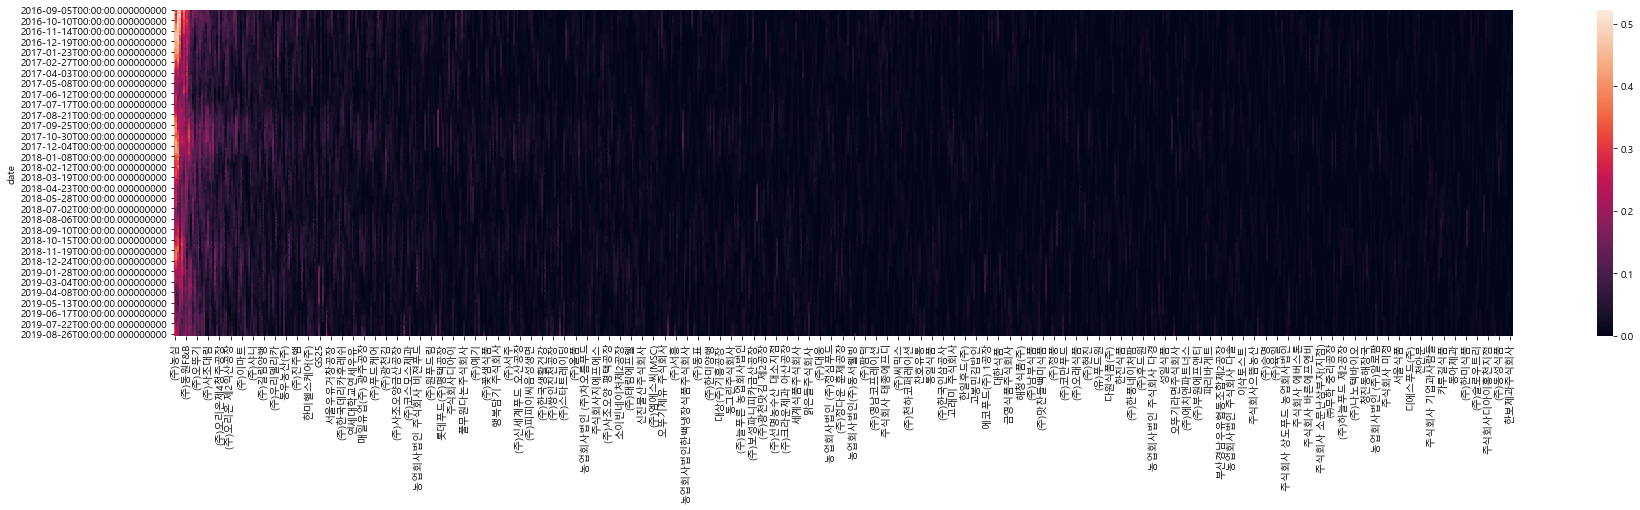

In [102]:
plt.subplots(figsize=(30,6))
ax = sns.heatmap(tf)

## 3.4  이상 징후 감지하기

In [103]:
tf.iloc[-1:]
tf.iloc[0:-1]

,(주)농심,롯데제과(주),롯데칠성음료(주),오뚜기라면(주),씨제이제일제당(주),매일유업(주)평택공장,(주)동원F&B,남양유업 주식회사 세종공장,동서식품(주),일동후디스(주),...,디아이커뮤니케이션,에이스식품,(주)동성식품,(주)엘림데리카후레쉬,거제사슴영농조합법인,(주)석보유통,도원,(주)리빙라이프,한보제과주식회사,황금터
date,,,,,,,,,,,,,,,,,,,,,
2019-08-30,0.322222,0.244444,0.211111,0.122222,0.133333,0.144444,0.211111,0.133333,0.155556,0.155556,...,0.055556,0.0,0.0,0.011111,0.0,0.011111,0.0,0.0,0.011111,0.0


,(주)농심,롯데제과(주),롯데칠성음료(주),오뚜기라면(주),씨제이제일제당(주),매일유업(주)평택공장,(주)동원F&B,남양유업 주식회사 세종공장,동서식품(주),일동후디스(주),...,디아이커뮤니케이션,에이스식품,(주)동성식품,(주)엘림데리카후레쉬,거제사슴영농조합법인,(주)석보유통,도원,(주)리빙라이프,한보제과주식회사,황금터
date,,,,,,,,,,,,,,,,,,,,,
2016-09-05,0.388889,0.266667,0.433333,0.477778,0.277778,0.355556,0.288889,0.266667,0.200000,0.077778,...,0.000000,0.000000,0.0,0.000000,0.011111,0.000000,0.000000,0.011111,0.000000,0.011111
2016-09-06,0.388889,0.266667,0.433333,0.500000,0.288889,0.366667,0.277778,0.266667,0.200000,0.077778,...,0.000000,0.000000,0.0,0.000000,0.011111,0.000000,0.000000,0.011111,0.000000,0.011111
2016-09-07,0.400000,0.266667,0.433333,0.477778,0.288889,0.377778,0.277778,0.266667,0.200000,0.077778,...,0.000000,0.000000,0.0,0.000000,0.011111,0.000000,0.000000,0.011111,0.000000,0.011111
2016-09-08,0.400000,0.266667,0.433333,0.477778,0.288889,0.377778,0.277778,0.266667,0.200000,0.077778,...,0.000000,0.011111,0.0,0.000000,0.011111,0.000000,0.000000,0.011111,0.000000,0.011111
2016-09-09,0.400000,0.288889,0.433333,0.477778,0.288889,0.377778,0.277778,0.266667,0.200000,0.077778,...,0.000000,0.011111,0.0,0.000000,0.011111,0.000000,0.000000,0.011111,0.000000,0.011111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-23,0.311111,0.222222,0.222222,0.111111,0.133333,0.133333,0.211111,0.133333,0.166667,0.144444,...,0.033333,0.000000,0.0,0.011111,0.000000,0.011111,0.011111,0.000000,0.011111,0.000000
2019-08-26,0.311111,0.244444,0.222222,0.111111,0.122222,0.133333,0.222222,0.133333,0.166667,0.144444,...,0.033333,0.000000,0.0,0.011111,0.000000,0.011111,0.000000,0.000000,0.011111,0.000000
2019-08-27,0.311111,0.244444,0.222222,0.111111,0.133333,0.144444,0.222222,0.133333,0.155556,0.155556,...,0.044444,0.000000,0.0,0.011111,0.000000,0.011111,0.000000,0.000000,0.011111,0.000000


In [104]:
anomaly = (tf.iloc[-1:] > tf.iloc[0:-1].mean() + 3*tf.iloc[0:-1].std()).T.reset_index()
anomaly.columns = ['업체', '감시기간']
anomaly_list = anomaly[anomaly['감시기간'] == True]['업체'].to_list()
','.join(anomaly_list)

'(주)크라운제과,세븐일레븐,매일유업(주) 광주공장,주식회사 샬롬,한일식품(주),풀무원다논주식회사,(주)놀부명과,참바다영어조합법인 멀티센터,(주)송학식품,(주)쌍인진천공장,CU편의점,cu편의점,(주)서흥,(주)라벨리,백만축산,(주)삼경프라자,별가식품,농업회사법인 유한회사 평강,원조할머니학화호도과자,(주)남부식품,(주)후레쉬퍼스트,(주)네추럴에프앤피 2공장,콜마비앤에이치(주) 푸디팜사업부문,(주)아띠인터내셔널,해태아이스크림(주),이마트24,대영식품,(주)엄마사랑,콜마비앤에이치(주)푸디팜사업부문,주식회사 상도푸드 농업회사법인,나누리영농조합,디아이커뮤니케이션'

(주)크라운제과


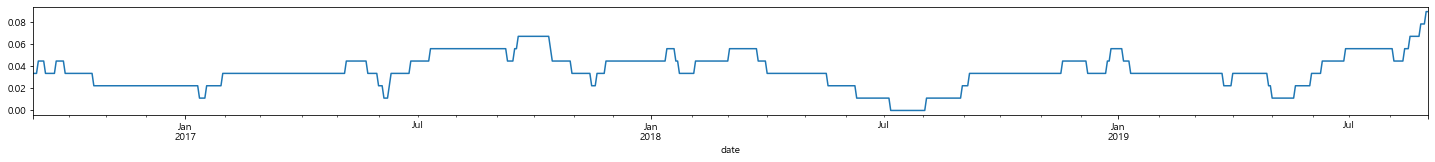

세븐일레븐


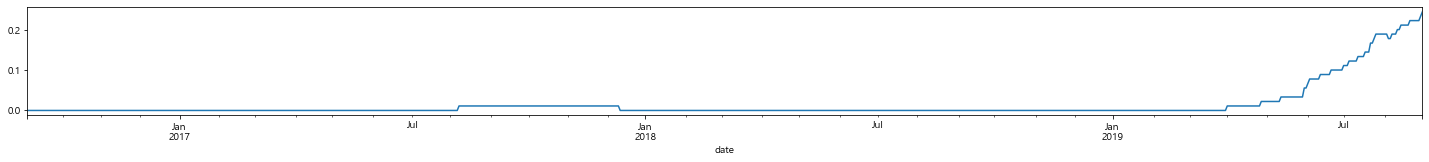

매일유업(주) 광주공장


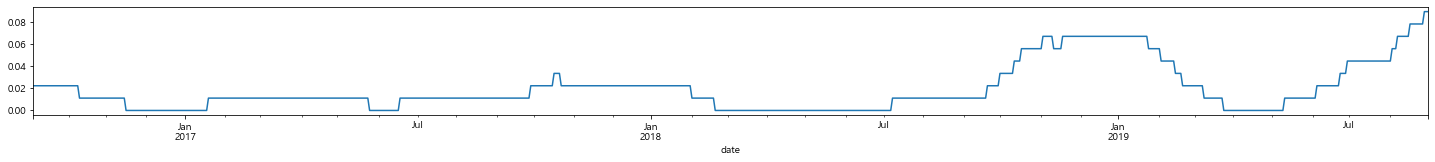

주식회사 샬롬


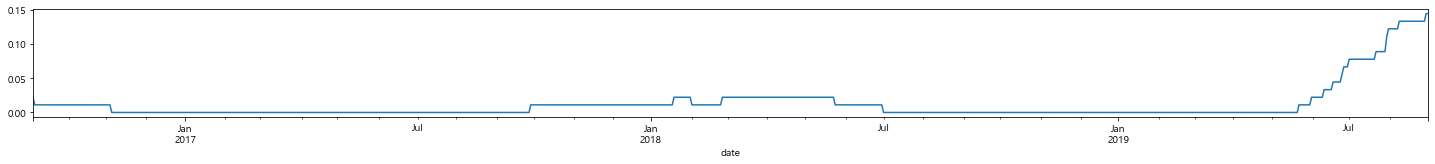

한일식품(주)


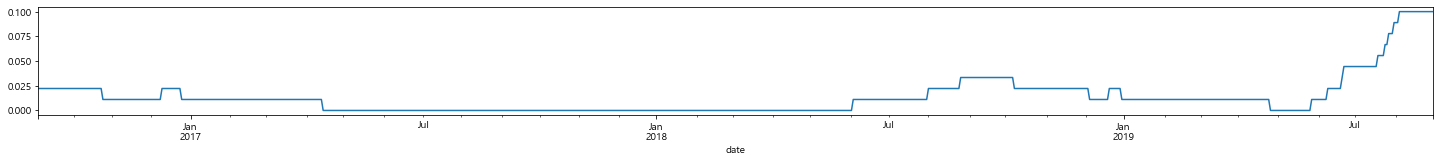

풀무원다논주식회사


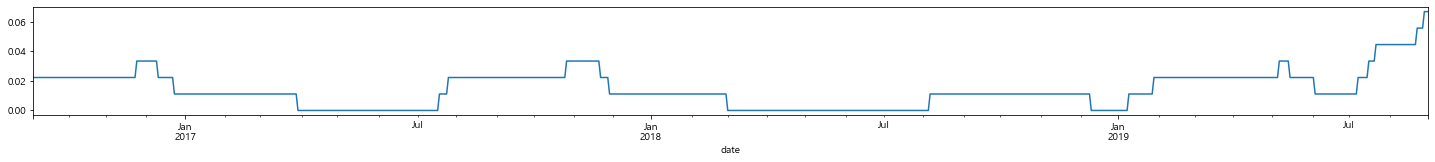

(주)놀부명과


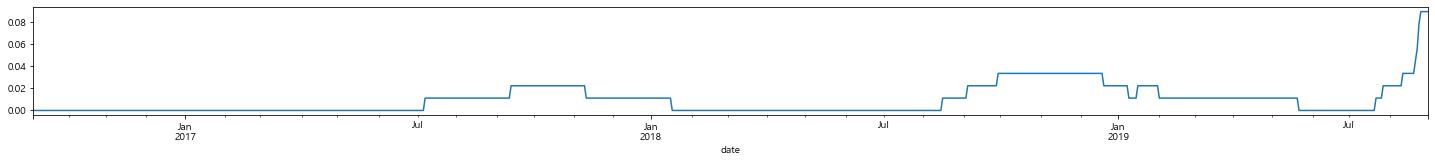

참바다영어조합법인 멀티센터


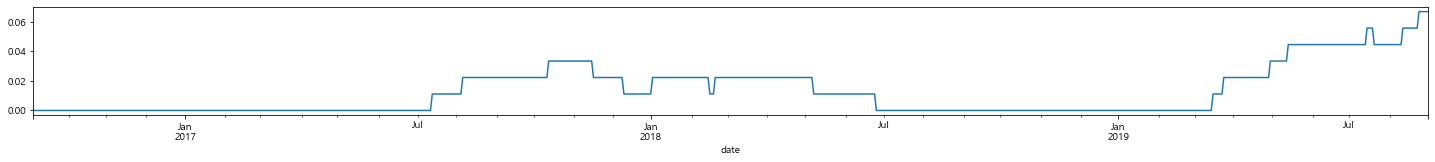

(주)송학식품


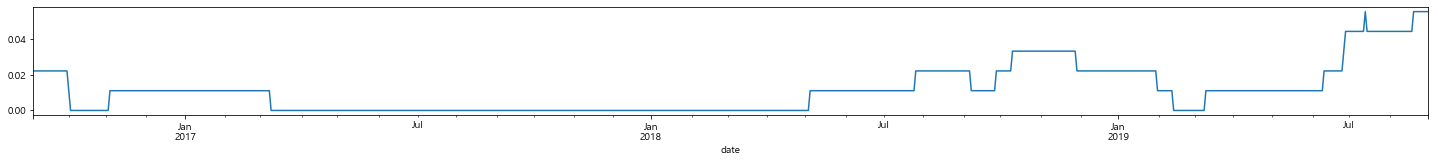

(주)쌍인진천공장


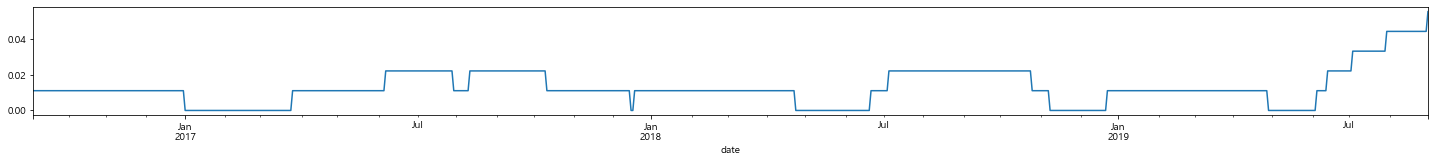

CU편의점


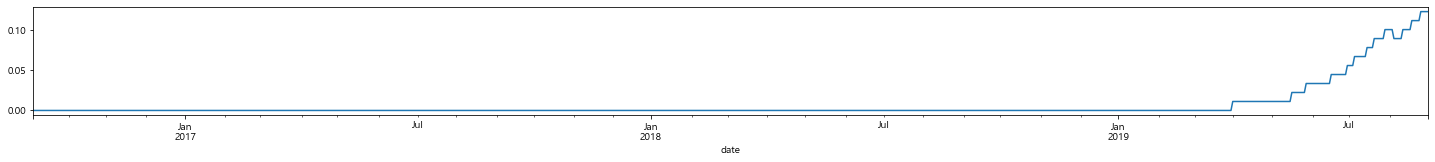

cu편의점


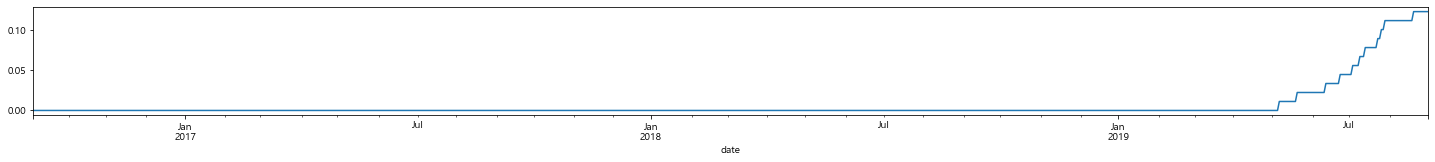

(주)서흥


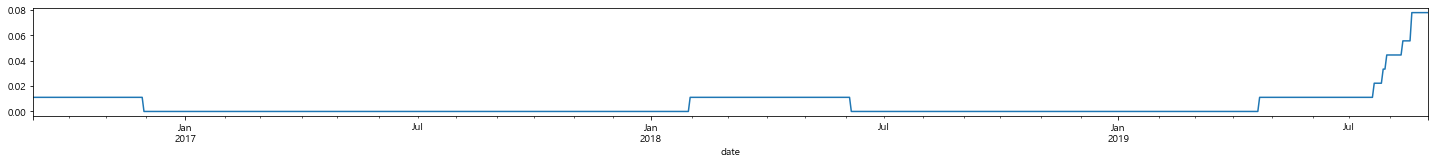

(주)라벨리


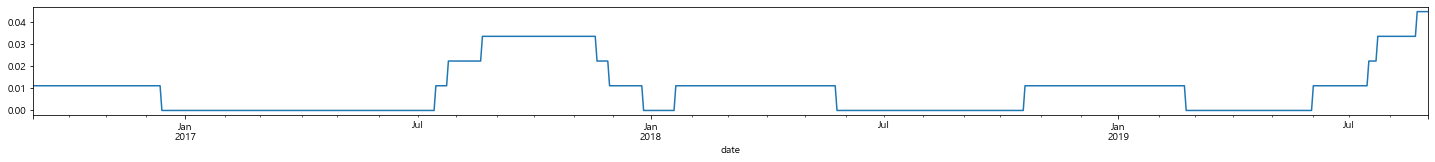

백만축산


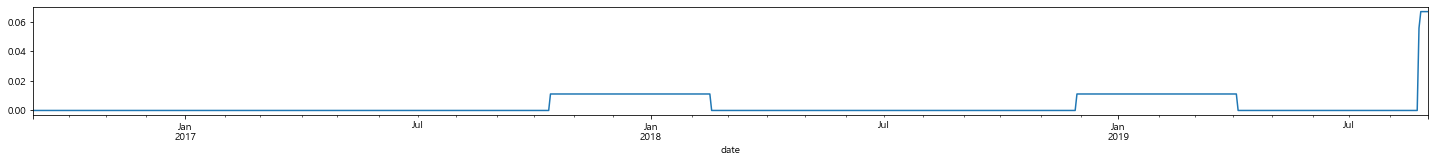

(주)삼경프라자


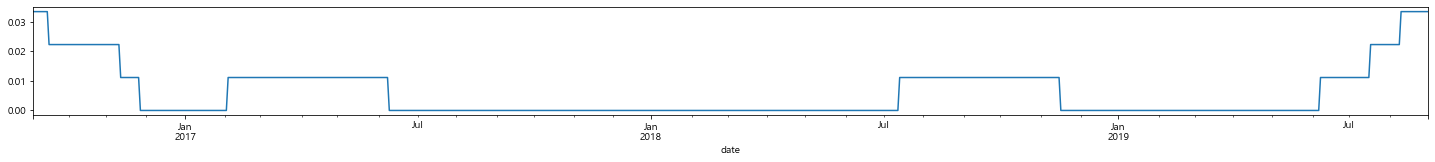

별가식품


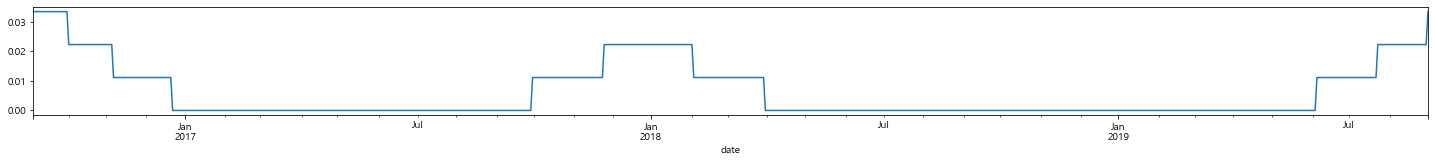

농업회사법인 유한회사 평강


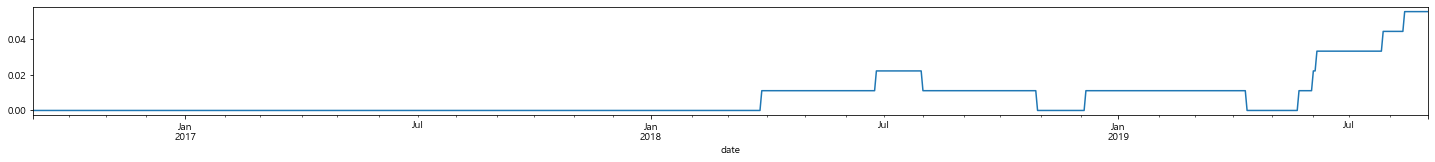

원조할머니학화호도과자


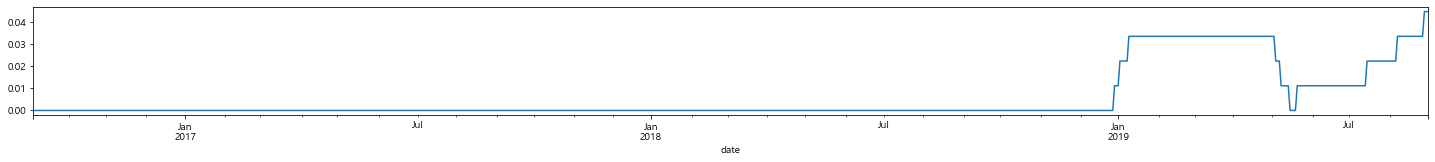

(주)남부식품


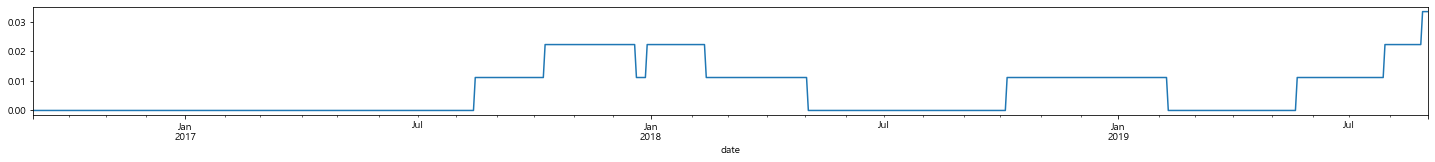

(주)후레쉬퍼스트


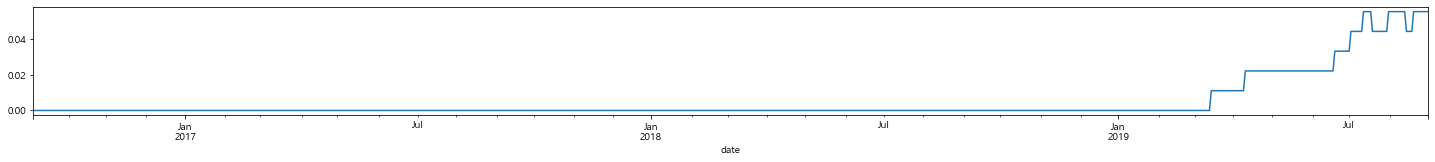

(주)네추럴에프앤피 2공장


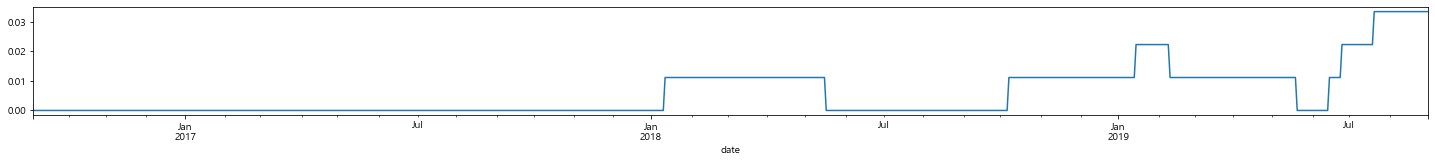

콜마비앤에이치(주) 푸디팜사업부문


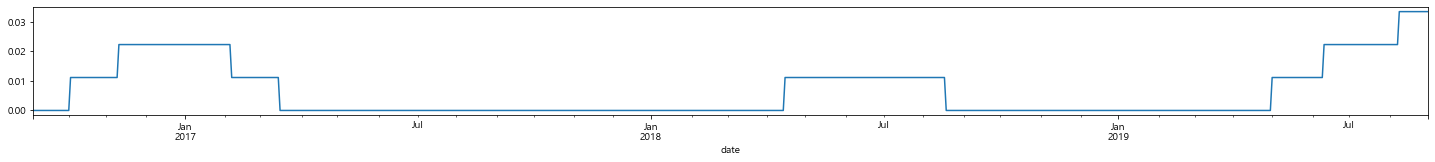

(주)아띠인터내셔널


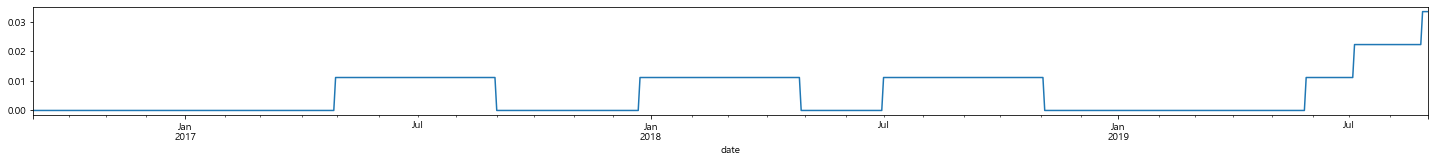

해태아이스크림(주)


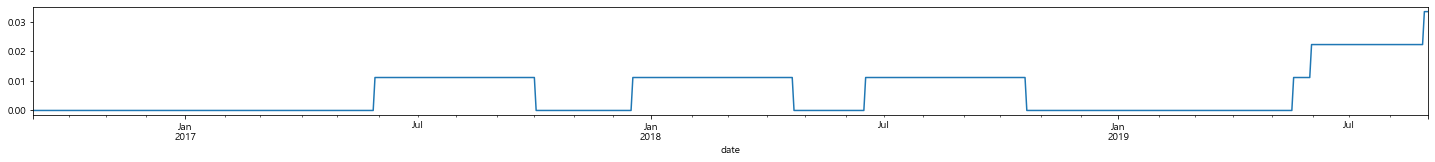

이마트24


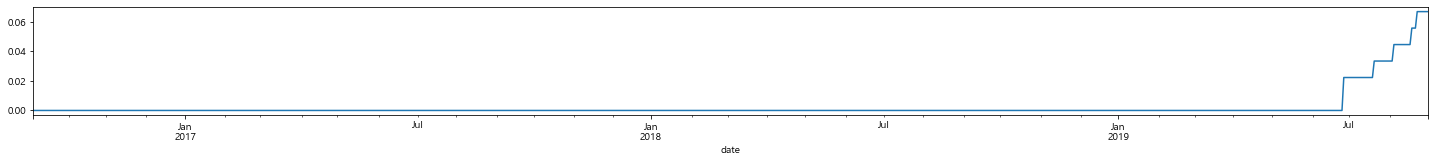

대영식품


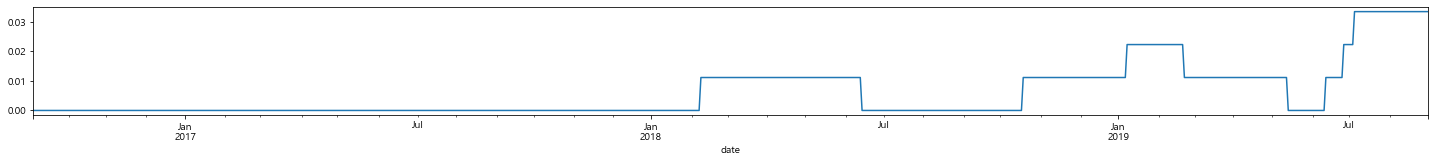

(주)엄마사랑


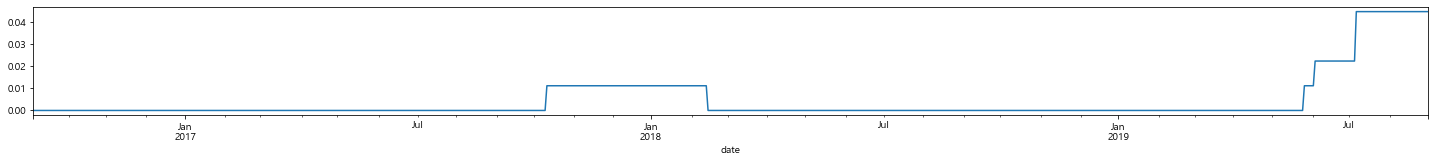

콜마비앤에이치(주)푸디팜사업부문


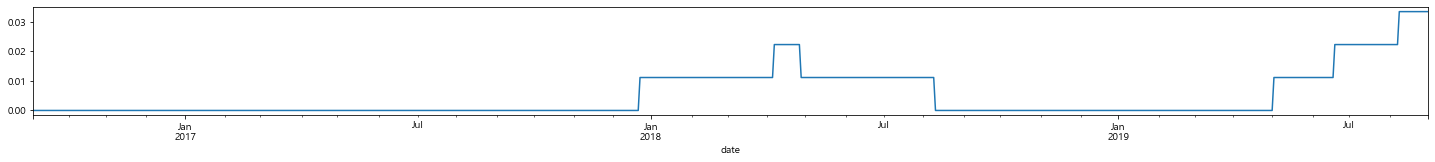

주식회사 상도푸드 농업회사법인


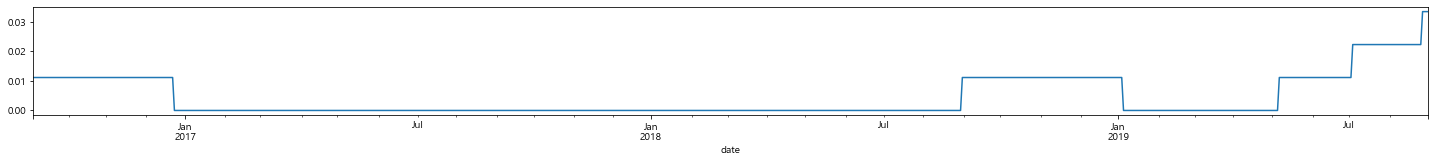

나누리영농조합


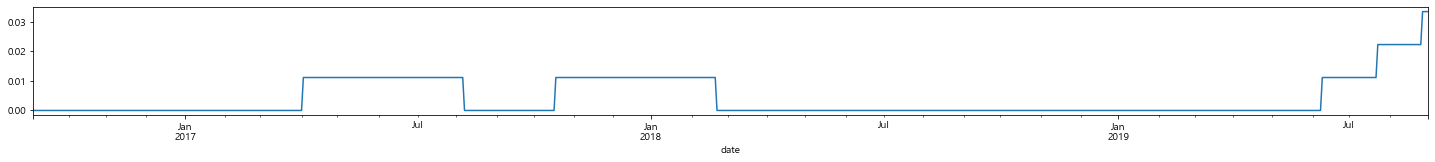

디아이커뮤니케이션


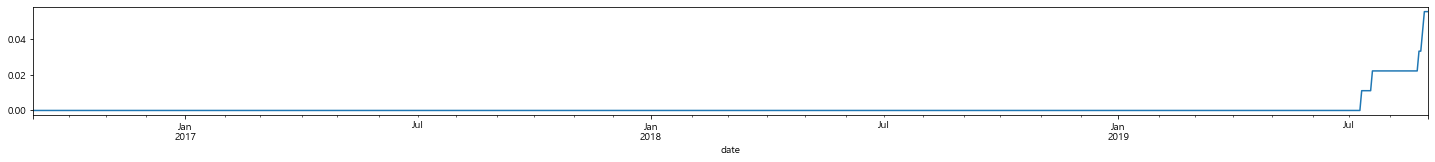

In [105]:
for co_name in anomaly_list:
    print(co_name)
    tf[co_name].plot(figsize=(25,2)); plt.show()

# 4. 이상 징후탐색 기간에 새롭게 나타난 업체
- 3.2에 해당되는 업체(extract_company)

In [106]:
df = extract_company(min_calls, df[(df['신고일시'] >= start_date - pd.Timedelta(str(rolling_days) + ' days')) &
                                   (df['신고일시'] <= base_date)]) # 적어도 과거에 5건의 민원신고 업체
df.shape

대상업체 수 722


(10583, 4)

In [107]:
df_T = df[(df['신고일시'] >= start_date) & (df['신고일시'] <= end_date)] # T 기간동안 데이터 
df_T.shape
df_t = df[(df['신고일시'] > end_date) & (df['신고일시'] <= base_date)] # t 기간동안 데이터
df_t.shape

(9394, 4)

(300, 4)

In [108]:
def find_new (col, tf, sf) :
    print('첫번째 데이터의 개수는 {} 이다.'.format(len(set(tf[col].to_list()))))
    print('두번째 데이터의 개수는 {} 이다.'.format(len(set(sf[col].to_list()))))
    print('두 데이터의 합집합 수는 {} 이다.'.format(len(set(tf[col].to_list()) | set(sf[col].to_list())))) # 합집합
    print('두 데이터의 교집합 수는 {} 이다.'.format(len(set(tf[col].to_list()) & set(sf[col].to_list())))) # 교집합
    print('두번째에는 있고 첫번째에는 없는 데이터수는 {} 이다.'.format(len(set(sf[col].to_list()) - set(tf[col].to_list())))) # 차집합
    print('*'*100)
    print('두번째에는 있지만 첫번째 데이터에는 없는 데이터 내용은(new_incombants) :.')
    print('*'*100)
    print(', '.join(list((set(sf[col].to_list()) - set(tf[col].to_list())))))
    
    return list((set(sf[col].to_list()) - set(tf[col].to_list()))) # 차집합의 원소 내용 반환

In [109]:
new_incombants = find_new ('제조원', df_T, df_t) # T, t기간동안의 데이터프레임 비교

첫번째 데이터의 개수는 722 이다.
두번째 데이터의 개수는 193 이다.
두 데이터의 합집합 수는 722 이다.
두 데이터의 교집합 수는 193 이다.
두번째에는 있고 첫번째에는 없는 데이터수는 0 이다.
****************************************************************************************************
두번째에는 있지만 첫번째 데이터에는 없는 데이터 내용은(new_incombants) :.
****************************************************************************************************



# 5. 포아송확률분포로 찾아보기

### 제조원별 T, t 기간동안 발생한 신고민원 건수 통계

In [110]:
df_T = df[(df['신고일시'] >= start_date) & (df['신고일시'] <= end_date)].groupby('제조원')['신고일시'].count().reset_index().rename(columns = {'신고일시' : 'T_count'})
df = pd.merge(df, df_T, on='제조원', how='left')

df_t = df[(df['신고일시'] >= end_date) & (df['신고일시'] <= base_date)].groupby('제조원')['신고일시'].count().reset_index().rename(columns = {'신고일시' : 't_count'})
df = pd.merge(df, df_t, on='제조원', how='left')

df.drop_duplicates(['제조원'], keep='first', inplace = True)
del df['신고건수']

### lambda 구하기 (단위시간의 평균) 즉 lambda_t = (lambda * t)/T 

In [111]:
df['t_count'] = df['t_count'].fillna(0) # 이상치 확인 기간동안 발생하지 않은 것은 zero로 처리

df['lambda'] = df['T_count'] / ma_period # 과거 민원신고기간(일수) days 혹은 이동평균산정 기간
df['lambda_t'] = df['lambda'] * alert_period
df['proba'] = poisson(df['lambda']*alert_period).pmf(df['t_count'])
df['anomaly'] = df['t_count'] - df['lambda_t']

df.sort_values(by = 'anomaly', ascending = False, inplace=True)

### Abnormal detection : 특이하게 민원이 많은 업체 리스트
- t동안 평균 신고민원 건수보다 실제민원 건수가 많은 경우를 extract
- 확률(proba)가 0.1보다 적은 업체를 추출

In [112]:
df[(df['lambda_t'] < df['t_count']) & (df['proba'] <= 0.1)].sort_values(by = 'anomaly', ascending = False) # t동안 평균 신고민원 건수보다 실제민원 건수가 많은 경우를 extract
anomaly_list_poisson = df[(df['lambda_t'] < df['t_count']) & (df['proba'] <= 0.1)].sort_values(by = 'anomaly', ascending = False)['제조원'].to_list()

,신고일시,제조원,제품명,T_count,t_count,lambda,lambda_t,proba,anomaly
3952,2017-08-08,세븐일레븐,후라이드치킨,18,7.0,0.016438,0.493151,8.595167e-07,6.506849
4793,2017-10-13,백만축산,무항생제 신선란,2,6.0,0.001826,0.054795,3.558716e-11,5.945205
3600,2017-07-07,(주)놀부명과,마늘바게트,8,6.0,0.007306,0.219178,1.236694e-07,5.780822
429,2016-06-20,남양유업 주식회사 천안신공장,프렌치카페 카페오레,28,5.0,0.025571,0.767123,1.027986e-03,4.232877
845,2016-07-27,(주)서흥,키즈오메가-3,5,4.0,0.004566,0.136986,1.279396e-05,3.863014
310,2016-06-07,매일유업(주) 광주공장,휘핑크림,15,4.0,0.013699,0.410959,7.879618e-04,3.589041
403,2016-06-15,부산우유협동조합,부산우유 1A,17,4.0,0.015525,0.465753,1.230662e-03,3.534247
8473,2019-01-02,GS25,베이컨말이소시지,22,4.0,0.020091,0.602740,3.009827e-03,3.397260
60,2016-05-11,(주)크라운제과,쵸코파이,28,4.0,0.025571,0.767123,6.700266e-03,3.232877
34,2016-05-09,롯데제과(주),에이비씨초코,216,9.0,0.197260,5.917808,6.601057e-02,3.082192


# <font color='red'> 6. 정규분포(이동평균)와 포아송분포(단순평균)를 비교해 보기  
- 이동평균을 사용한 포아송분포를 확인하여 포아송확률로 예측해 보길!! 나중에 (이동평균의 사건 발생수를 정수화하여야 함)

In [113]:
set(anomaly_list) & set(anomaly_list_poisson) # 교집합

{'(주)놀부명과',
 '(주)삼경프라자',
 '(주)서흥',
 '(주)크라운제과',
 'CU편의점',
 '나누리영농조합',
 '디아이커뮤니케이션',
 '매일유업(주) 광주공장',
 '백만축산',
 '세븐일레븐',
 '원조할머니학화호도과자',
 '이마트24',
 '주식회사 상도푸드 농업회사법인',
 '주식회사 샬롬',
 '참바다영어조합법인 멀티센터',
 '콜마비앤에이치(주)푸디팜사업부문',
 '풀무원다논주식회사'}

(주)놀부명과


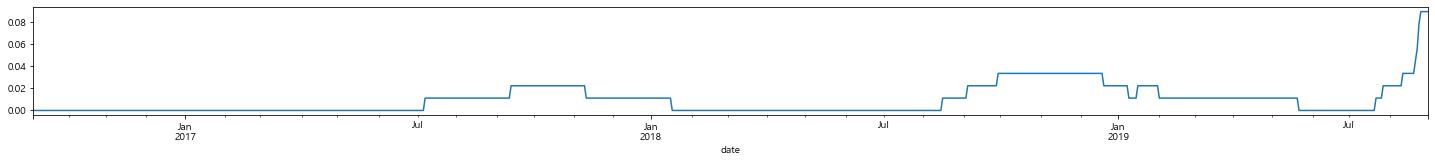

(주)삼경프라자


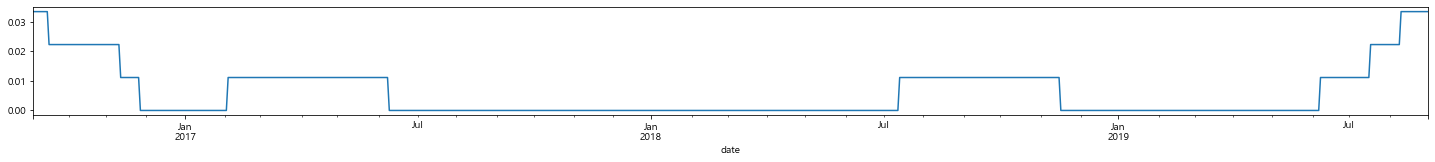

(주)서흥


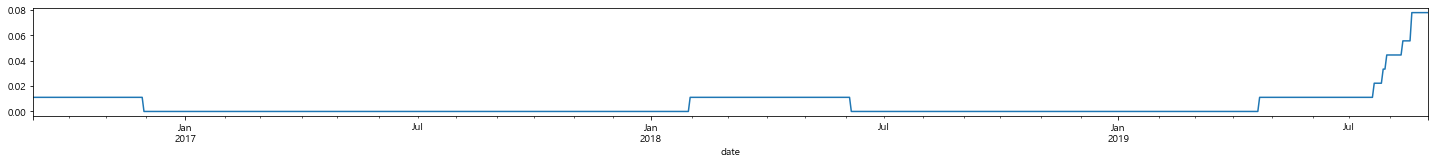

(주)크라운제과


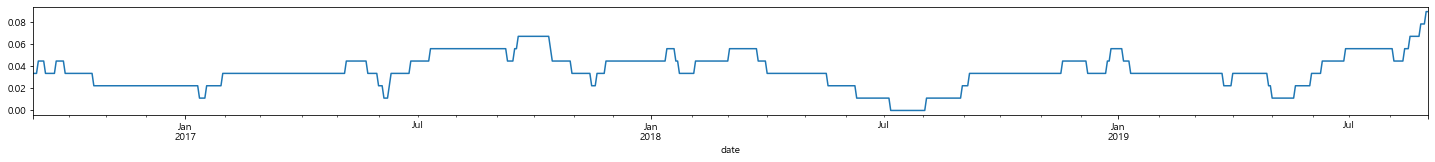

CU편의점


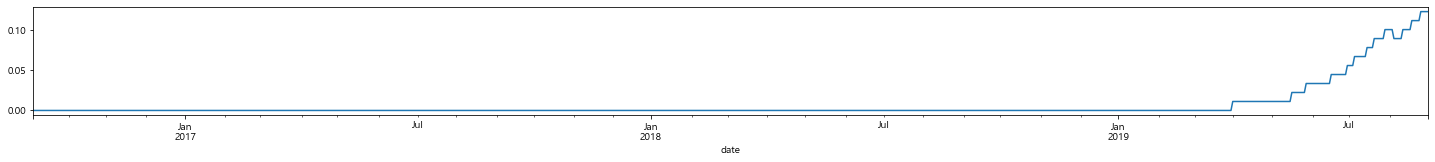

나누리영농조합


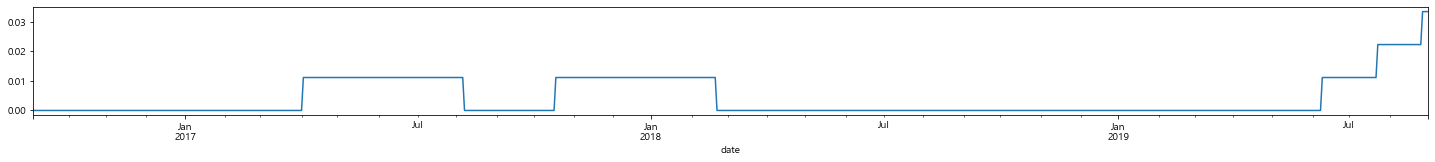

디아이커뮤니케이션


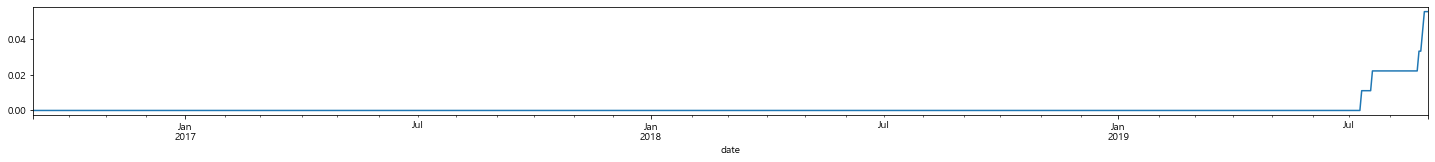

매일유업(주) 광주공장


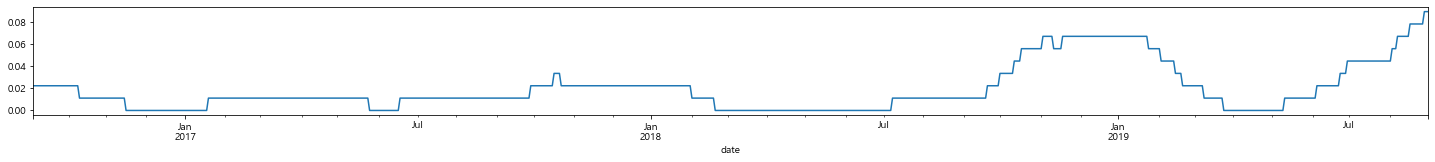

백만축산


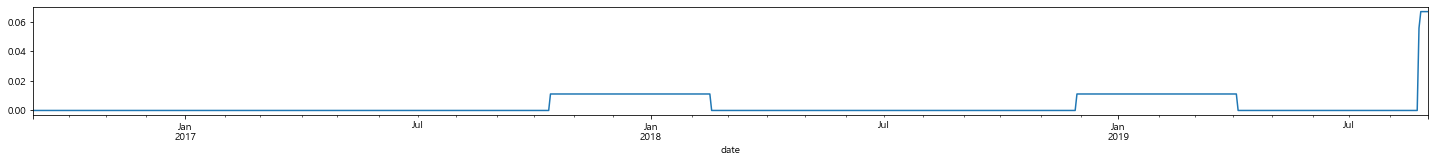

세븐일레븐


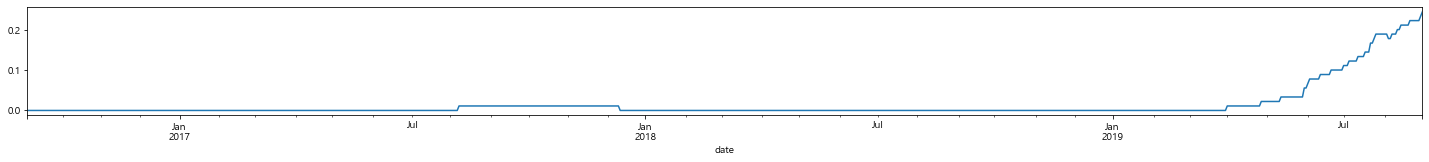

원조할머니학화호도과자


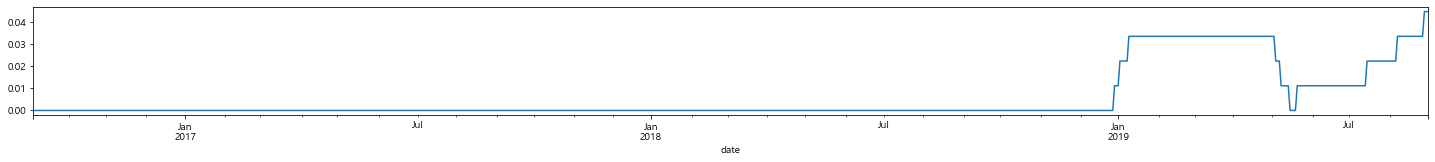

이마트24


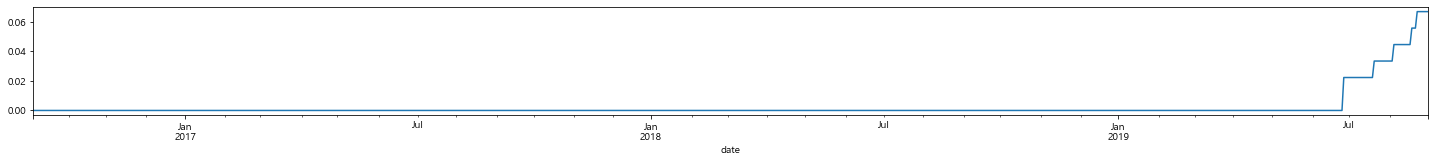

주식회사 상도푸드 농업회사법인


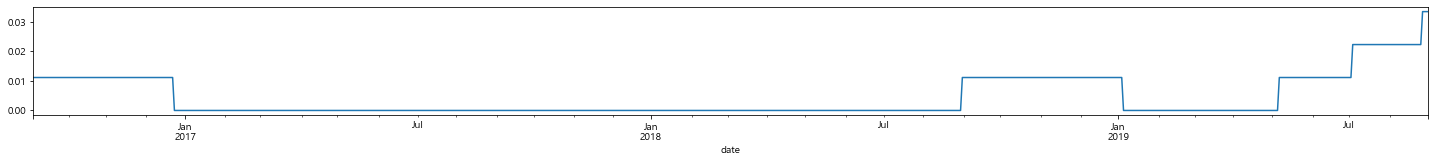

주식회사 샬롬


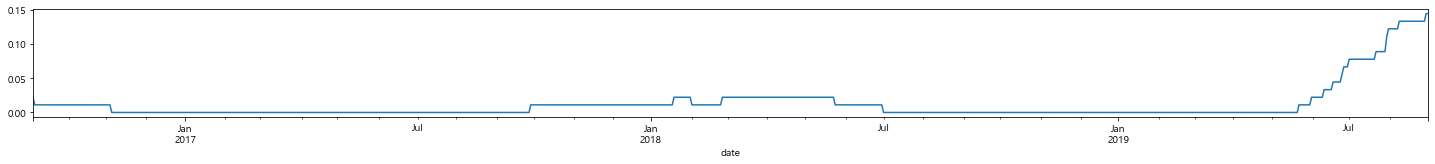

참바다영어조합법인 멀티센터


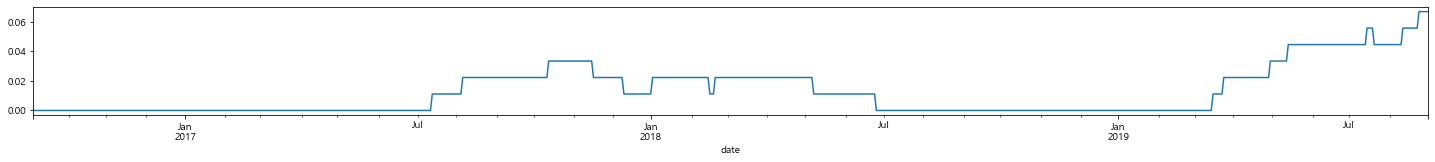

콜마비앤에이치(주)푸디팜사업부문


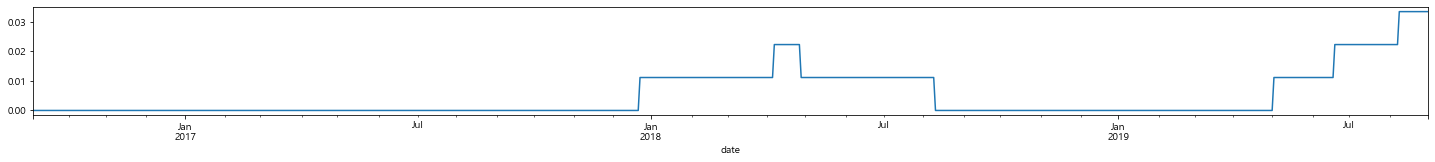

풀무원다논주식회사


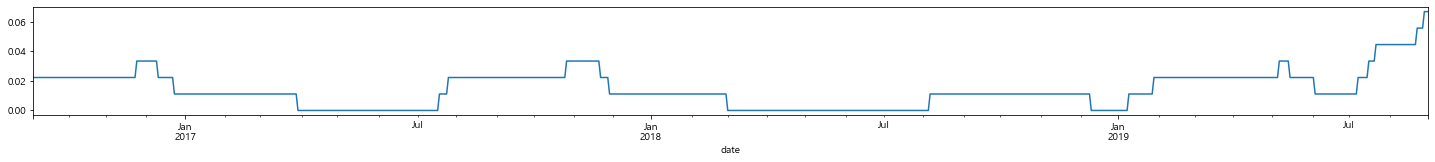

In [114]:
for co_name in sorted(set(anomaly_list) & set(anomaly_list_poisson)):
    print(co_name)
    tf[co_name].plot(figsize=(25,2)); plt.show()